# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
# from lightning.pytorch import seed_everything
# seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
from matplotlib import cm
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------
### 実験設定

In [2]:
TARGET = "PM_US Post"
THRESHOLD = 2  # 外れ値除外の閾値

RANDOM_STATE = 0  # 乱数シード

N_CLUSTERS = 10
K_MIN = 2
K_MAX = 10

-----------
### データの前処理（Data Preprocessing）

In [3]:
# df_Beijing = pd.read_csv(
#     R"C:\Users\HaruMomozu\Documents\中国気象データ\BeijingPM20100101_20151231.csv"
# )
# df_Chengdu = pd.read_csv(
#     R"C:\Users\HaruMomozu\Documents\中国気象データ\ChengduPM20100101_20151231.csv"
# )
# df_Guangzhou = pd.read_csv(
#     R"C:\Users\HaruMomozu\Documents\中国気象データ\GuangzhouPM20100101_20151231.csv"
# )
# df_Shanghai = pd.read_csv(
#     R"C:\Users\HaruMomozu\Documents\中国気象データ\ShanghaiPM20100101_20151231.csv"
# )
# df_Shenyang = pd.read_csv(
#     R"C:\Users\HaruMomozu\Documents\中国気象データ\ShenyangPM20100101_20151231.csv"
# )


In [4]:
df_Beijing = pd.read_csv(
    R"C:\Users\tsuki\Documents\研究室\研究\ABテスト実装\オンラインデータ\中国気象データ\BeijingPM20100101_20151231.csv"
)
df_Chengdu = pd.read_csv(
    R"C:\Users\tsuki\Documents\研究室\研究\ABテスト実装\オンラインデータ\中国気象データ\ChengduPM20100101_20151231.csv"
)
df_Guangzhou = pd.read_csv(
    R"C:\Users\tsuki\Documents\研究室\研究\ABテスト実装\オンラインデータ\中国気象データ\GuangzhouPM20100101_20151231.csv"
)
df_Shanghai = pd.read_csv(
    R"C:\Users\tsuki\Documents\研究室\研究\ABテスト実装\オンラインデータ\中国気象データ\ShanghaiPM20100101_20151231.csv"
)
df_Shenyang = pd.read_csv(
    R"C:\Users\tsuki\Documents\研究室\研究\ABテスト実装\オンラインデータ\中国気象データ\ShenyangPM20100101_20151231.csv"
)

In [5]:
df_Beijing["city"] = "Beijing"
df_Chengdu["city"] = "Chengdu"
df_Guangzhou["city"] = "Guangzhou"
df_Shanghai["city"] = "Shanghai"
df_Shenyang["city"] = "Shenyang"

In [6]:
df_all = pd.concat(
    [df_Beijing, df_Chengdu, df_Guangzhou, df_Shanghai, df_Shenyang],
    axis=0,
    ignore_index=True,
)

features_list_con = [
    "DEWP",
    "TEMP",
    "HUMI",
    "PRES",
    "Iws",
    "precipitation",
    "Iprec",
    "hour",
]
features_list_cat = ["city", "season", "cbwd"]

features_list = features_list_con + features_list_cat
variables_list = [TARGET] + features_list_con + features_list_cat

print(variables_list)

['PM_US Post', 'DEWP', 'TEMP', 'HUMI', 'PRES', 'Iws', 'precipitation', 'Iprec', 'hour', 'city', 'season', 'cbwd']


In [7]:
df_all_encoded = pd.get_dummies(df_all, columns=features_list_cat)
print(df_all_encoded)


           No  year  month  day  hour  PM_Dongsi  PM_Dongsihuan  \
0           1  2010      1    1     0        NaN            NaN   
1           2  2010      1    1     1        NaN            NaN   
2           3  2010      1    1     2        NaN            NaN   
3           4  2010      1    1     3        NaN            NaN   
4           5  2010      1    1     4        NaN            NaN   
...       ...   ...    ...  ...   ...        ...            ...   
262915  52580  2015     12   31    19        NaN            NaN   
262916  52581  2015     12   31    20        NaN            NaN   
262917  52582  2015     12   31    21        NaN            NaN   
262918  52583  2015     12   31    22        NaN            NaN   
262919  52584  2015     12   31    23        NaN            NaN   

        PM_Nongzhanguan  PM_US Post  DEWP  ...  city_Shenyang  season_1.0  \
0                   NaN         NaN -21.0  ...          False       False   
1                   NaN         NaN -21.0

In [8]:
cat_columns_dict = {}
cat_columns_list = []
for f in features_list_cat:
    col_list = [col for col in df_all_encoded.columns if col.startswith(f)]
    cat_columns_dict[f] = col_list
    cat_columns_list = cat_columns_list + col_list

columns_list_features = features_list_con + cat_columns_list
columns_list = [TARGET] + features_list_con + cat_columns_list

print("cat_columns_dict:", cat_columns_dict)
print("cat_columns_list:", cat_columns_list)
print("columns_list_features:", columns_list_features)
print("columns_list:", columns_list)


cat_columns_dict: {'city': ['city_Beijing', 'city_Chengdu', 'city_Guangzhou', 'city_Shanghai', 'city_Shenyang'], 'season': ['season_1.0', 'season_2.0', 'season_3.0', 'season_4.0'], 'cbwd': ['cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_SW', 'cbwd_cv']}
cat_columns_list: ['city_Beijing', 'city_Chengdu', 'city_Guangzhou', 'city_Shanghai', 'city_Shenyang', 'season_1.0', 'season_2.0', 'season_3.0', 'season_4.0', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_SW', 'cbwd_cv']
columns_list_features: ['DEWP', 'TEMP', 'HUMI', 'PRES', 'Iws', 'precipitation', 'Iprec', 'hour', 'city_Beijing', 'city_Chengdu', 'city_Guangzhou', 'city_Shanghai', 'city_Shenyang', 'season_1.0', 'season_2.0', 'season_3.0', 'season_4.0', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_SW', 'cbwd_cv']
columns_list: ['PM_US Post', 'DEWP', 'TEMP', 'HUMI', 'PRES', 'Iws', 'precipitation', 'Iprec', 'hour', 'city_Beijing', 'city_Chengdu', 'city_Guangzhou', 'city_Shanghai', 'city_Shenyang', 'season_1.0', 'season_2.0', 'season_3.0', 'season_4.0', 'cbwd_

In [9]:
df_2014 = df_all_encoded[df_all["year"] == 2014][columns_list]
df_2015 = df_all_encoded[df_all["year"] == 2015][columns_list]
print(df_2014)
print(df_2015)


        PM_US Post  DEWP  TEMP   HUMI    PRES     Iws  precipitation  Iprec  \
35064         53.0 -20.0   7.0  12.00  1014.0  143.48            0.0    0.0   
35065         65.0 -20.0   7.0  12.00  1013.0  147.50            0.0    0.0   
35066         70.0 -20.0   6.0  13.00  1013.0  151.52            0.0    0.0   
35067         79.0 -20.0   6.0  13.00  1013.0  153.31            0.0    0.0   
35068         92.0 -18.0   3.0  19.00  1012.0    0.89            0.0    0.0   
...            ...   ...   ...    ...     ...     ...            ...    ...   
254155        38.0 -20.0 -10.0  43.68  1026.0   51.00            0.0    0.0   
254156        36.0 -21.0 -10.0  40.04  1026.0   55.00            0.0    0.0   
254157        31.0 -21.0 -11.0  43.36  1027.0   59.00            0.0    0.0   
254158        30.0 -21.0 -11.0  43.36  1027.0   64.00            0.0    0.0   
254159        26.0 -21.0 -12.0  46.98  1027.0   68.00            0.0    0.0   

        hour  city_Beijing  ...  city_Shenyang  sea

In [10]:
def remove_nan(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    # 各列に対して、pd.to_numericを使用して数値に変換（エラーがあればNaNにする）
    df_numeric = data.apply(lambda col: pd.to_numeric(col, errors="coerce"))

    # 数値に変換できなかった行を抽出（NaNを含む行）
    df_excluded = data[df_numeric.isna().any(axis=1)]

    # NaNを含む行を削除
    df_clean = df_numeric.dropna()

    return df_excluded, df_clean

In [11]:
_, df_2014_clean = remove_nan(df_2014)
_, df_2015_clean = remove_nan(df_2015)

print("全データ数（訓練）：", len(df_2014))
print("全データ数（テスト）：", len(df_2015))
print("欠損値除去後のデータ数（訓練）：", len(df_2014_clean))
print("欠損値除去後のデータ数（テスト）：", len(df_2015_clean))

全データ数（訓練）： 43800
全データ数（テスト）： 43800
欠損値除去後のデータ数（訓練）： 40334
欠損値除去後のデータ数（テスト）： 39098


In [12]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

In [13]:
df_train = remove_outliers_zscore(
    data=df_2014_clean, metric=TARGET, threshold=THRESHOLD
)
df_train = df_train.reset_index(drop=True)  # 行を詰める
df_test = remove_outliers_zscore(data=df_2015_clean, metric=TARGET, threshold=THRESHOLD)
df_test = df_test.reset_index(drop=True)  # 行を詰める

print("欠損値と外れ値除外後のデータ数（訓練）:", len(df_train))
print("欠損値と外れ値除外後のデータ数（テスト）:", len(df_test))

欠損値と外れ値除外後のデータ数（訓練）: 38559
欠損値と外れ値除外後のデータ数（テスト）: 37237


In [14]:
X_train = df_train[columns_list_features].to_numpy()
y_train = df_train[TARGET].to_numpy()

X_test = df_test[columns_list_features].to_numpy()
y_test = df_test[TARGET].to_numpy()

In [15]:
sc = StandardScaler()
# 訓練データに基づいてfit
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

-------------
### Kmeansのクラスタ数確認

In [16]:
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
labels = kmeans.fit_predict(X_test_std)
cluster_size = np.bincount(labels)

print(cluster_size)

[5710 5548 3591 4194 2748 3875 4215 4193  357 2806]


-------------
### Xmeans で確認

##### Xmeans

In [17]:
# def compute_bic(X, kmeans):
#     labels = kmeans.labels_
#     clusters = kmeans.cluster_centers_
#     n_clusters = len(clusters)
#     n = len(X)
#     m = X.shape[1]
#     variance = np.sum(
#         [
#             np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
#             for i in range(n_clusters)
#         ]
#     )
#     bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
#     return bic


# def xmeans(X, k_min=2, k_max=10):
#     kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
#     kmeans.fit(X)
#     best_bic = compute_bic(X, kmeans)
#     best_k = k_min
#     score_dict = {}
#     score_dict[k_min] = best_bic
#     for k in range(k_min + 1, k_max + 1):
#         kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
#         kmeans.fit(X)
#         current_bic = compute_bic(X, kmeans)
#         score_dict[k] = current_bic
#         if current_bic < best_bic:
#             best_bic = current_bic
#             best_k = k
#     return best_k, score_dict

##### クラスタリング結果

In [18]:
# best_k, score_dict = xmeans(X_train_std, k_min=K_MIN, k_max=K_MAX)
# print("n_clusters chosen in Xmeans:", best_k)

# x = []
# for k in score_dict.keys():
#     x.append(str(k))
# y = [score for score in score_dict.values()]
# bars = plt.bar(x, y)
# plt.ylabel("BIC", fontsize=30)
# plt.xlabel("Number of clusters", fontsize=30)
# plt.tick_params(axis="both", which="major", labelsize=25)
# plt.tight_layout()
# plt.show()

-----------------------------
### シルエット係数で確認

In [19]:
def silhouette(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    best_score = silhouette_score(X, labels)
    score_dict = {}
    score_dict[k_min] = best_score
    best_k = k_min
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        labels = kmeans.predict(X)
        current_score = silhouette_score(X, labels)
        score_dict[k] = current_score
        if current_score > best_score:
            best_score = current_score
            best_k = k
    return best_k, score_dict

##### 結果

n_clusters chosen in Xmeans: 8


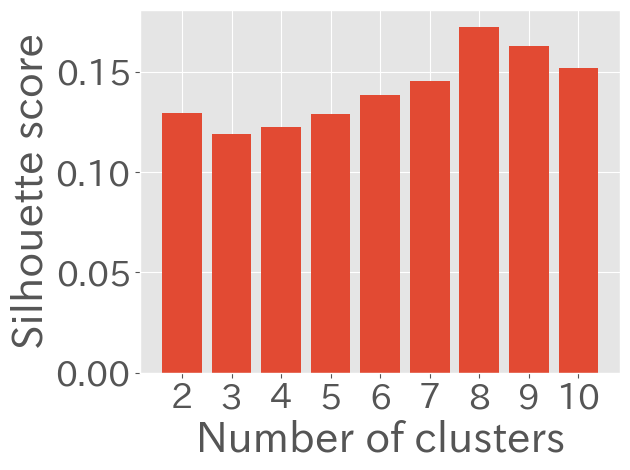

In [20]:
best_k, score_dict = silhouette(X_train_std, k_min=K_MIN, k_max=K_MAX)
print("n_clusters chosen in Xmeans:", best_k)

x = []
for k in score_dict.keys():
    x.append(str(k))
y = [score for score in score_dict.values()]
bars = plt.bar(x, y)
plt.ylabel("Silhouette score", fontsize=30)
plt.xlabel("Number of clusters", fontsize=30)
plt.tick_params(axis="both", which="major", labelsize=25)
plt.tight_layout()
plt.show()

In [21]:
print(score_dict)

{2: 0.12929006211590277, 3: 0.1187879179934751, 4: 0.12251573174879803, 5: 0.12893285001089333, 6: 0.1385615302865148, 7: 0.14534642545306478, 8: 0.17216872426281735, 9: 0.16302590663655026, 10: 0.15164342259291957}


### シルエット図

In [22]:
# def plot_silhouette_diagram(n_clusters: int, X):
#     kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
#     labels = kmeans.fit_predict(X)
#     cluster_labels = np.unique(labels)
#     n_clusters = cluster_labels.shape[0]

#     silhouette_vals = silhouette_samples(X, labels, metric="euclidean")
#     y_ax_lower, y_ax_upper = 0, 0
#     yticks = []

#     for i, c in enumerate(cluster_labels):
#         c_silhouette_vals = silhouette_vals[labels == c]
#         c_silhouette_vals.sort()
#         y_ax_upper += len(c_silhouette_vals)
#         color = cm.jet(float(i) / n_clusters)
#         plt.barh(
#             range(y_ax_lower, y_ax_upper),
#             c_silhouette_vals,
#             height=1.0,
#             edgecolor="none",
#             color=color,
#         )
#         yticks.append((y_ax_lower + y_ax_upper) / 2.0)
#         y_ax_lower += len(c_silhouette_vals)

#     silhouette_avg = np.mean(silhouette_vals)
#     plt.axvline(silhouette_avg, color="red", linestyle="--")
#     plt.yticks(yticks, cluster_labels + 1)
#     plt.ylabel("Cluster", fontsize=30)
#     plt.xlabel("Silhouette coefficient", fontsize=30)
#     plt.tick_params(axis="both", which="major", labelsize=25)
#     plt.xlim(-0.6, 0.6)
#     plt.tight_layout()
#     plt.show()

In [23]:
# for n_clusters in range(K_MIN, K_MAX + 1):
#     plot_silhouette_diagram(n_clusters=n_clusters, X=X_train_std)

-----
## エルボー図

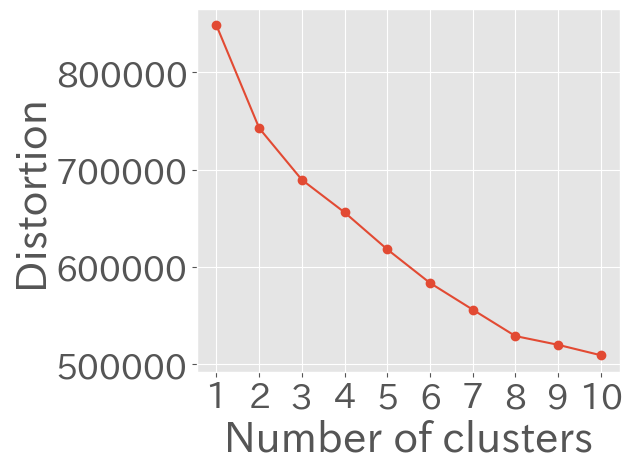

In [24]:
distortions = []
for i in range(K_MIN - 1, K_MAX + 1):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_train_std)
    distortions.append(kmeans.inertia_)

plt.plot(range(K_MIN - 1, K_MAX + 1), distortions, marker="o")
plt.xlabel("Number of clusters", fontsize=30)
plt.ylabel("Distortion", fontsize=30)
plt.xticks(range(K_MIN - 1, K_MAX + 1))
plt.tick_params(axis="both", labelsize=25)
plt.tight_layout()
plt.show()